In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import seaborn as sns
from intercluster.plotting import *

%load_ext autoreload
%autoreload 2

In [7]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 32
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(1), cmap(5), cmap(3), cmap(6), cmap(7), cmap(0), cmap(2)]
cmap_subset = ListedColormap(subset_colors)

distortion_colors = [cmap(5), cmap(1), cmap(3), cmap(6), cmap(7), cmap(0)]
distortion_cmap = ListedColormap(distortion_colors)

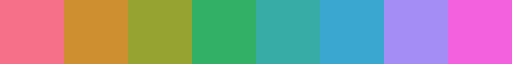

In [8]:
cmap

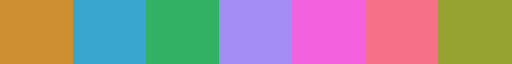

In [9]:
cmap_subset

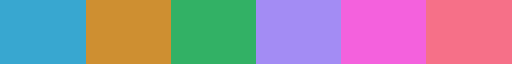

In [10]:
distortion_cmap

### Coverage-Cost Experiments

In [108]:
# Load experiment results
dataset = 'fashion'
fname = "../data/experiments/" + dataset + "/relative_coverage/exp_test.csv"
experiment_df = pd.read_csv(fname, header=[0, 1, 2, 3], index_col=0)

In [109]:
# Compute statistics:
grouped = experiment_df.T.groupby(level = [0,1,2])
mean_df = grouped.mean().T
std_df = grouped.std().T

In [83]:
table_df = mean_df.iloc[-4,:].to_frame()
table_df.loc['normalized-clustering-cost',:]

7
Forest-Depth-2   Forest-Depth-2    2.971514
                 IMM               3.402164
                 KMeans            2.525464
Forest-Depth-3   Forest-Depth-3    2.702635
                 IMM               3.374171
                 KMeans            2.483007
Forest-Depth-4   Forest-Depth-4    2.604723
                 IMM               3.363186
                 KMeans            2.457301
Forest-Depth-IMM Forest-Depth-IMM  2.742324
                 IMM               3.390092
                 KMeans            2.492624
IMM              IMM               3.472604
IMM-outliers     IMM               3.336999
                 IMM-outliers      3.125694
                 KMeans            2.366130
KMeans           KMeans            2.629534

In [110]:
mean_df['max-rule-length']['IMM'].iloc[0]

IMM    7.0
Name: 0, dtype: float64

In [111]:
mean_df['weighted-average-rule-length']['IMM'].iloc[0]

IMM    5.052857
Name: 0, dtype: float64

In [112]:
mean_df['normalized-clustering-cost']['IMM'].iloc[0]

IMM    39.30232
Name: 0, dtype: float64

In [113]:
# Interpretable Measurements Table
fname = "../data/experiments/" + dataset + "/measurements.csv"
inter_measures_df = pd.read_csv(fname, index_col=0)

In [114]:
inter_measures_df

,coverage,max-rule-length,normalized-clustering-cost,overlap,weighted-average-rule-length
Row,,,,,
forest_depth_2,0.819086,2.0,35.931166,1.160737,2.000000
forest_depth_3,0.809543,3.0,33.514345,1.113150,3.000000
forest_depth_4,0.835143,4.0,32.465939,1.075334,3.627513
forest_depth_imm,0.823486,7.0,32.379176,1.083755,3.802600
outlier,0.800057,7.0,37.777986,1.000000,5.032569


In [115]:
# And the associated explanation tree results:
fname = "../data/experiments/" + dataset + "/explanation_tree.csv"
explanation_tree_df = pd.read_csv(fname, index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '../data/experiments/fashion/explanation_tree.csv'

In [103]:
explanation_tree_df

,normalized-clustering-cost,overlap,coverage,max-rule-legnth,weighted-average-rule-length
0,35.019858,1.0,0.572171,8,6.133127


### Plotting

In [48]:
#colormap = no_oblique_cmap_subset
#module_list = [m for m in mean_df['normalized-clustering-cost'].columns if m not in baseline_list]
#module_list = [m for m in mean_df['normalized-clustering-cost'][model].columns]

#colormap = cmap_subset
colormap = distortion_cmap
baseline_list = ['KMeans-Full', 'IMM-Full']
#module_list = ['KMeans', 'IMM', 'Forest-Depth-2', 
#               'Forest-Depth-3','Forest-Depth-4', 'Forest-Depth-IMM','IMM-outliers']

module_list = ['IMM', 'IMM-outliers', 'Forest-Depth-2', 
               'Forest-Depth-3','Forest-Depth-4']
legend_module_list = [r'\texttt{IMM}', r'\texttt{IMM-outliers}', r'\texttt{Forest-Depth-2}', 
               r'\texttt{Forest-Depth-3}',r'\texttt{Forest-Depth-4}']
color_dict = {mod : i for i,mod in enumerate(module_list)}

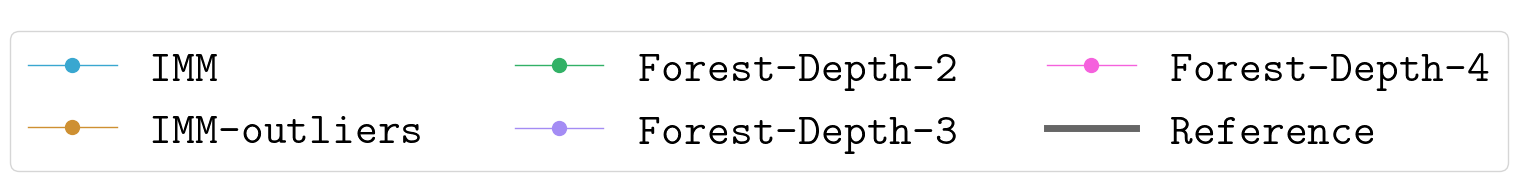

In [49]:
# Legend:
fig, ax = plt.subplots(figsize = (6,1))
legend_elements = [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=10,
        color=colormap(i),
        lw=1,
        label=mod,
        alpha=1
    )
    for i,mod in enumerate(legend_module_list)
]

'''
legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = 'dashed',
        label="IMM-Full",
        alpha=0.6
    )
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = '-',
        label="KMeans-Full",
        alpha=0.6
    )
]
'''
legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=5,
        linestyle = '-',
        label=r"\texttt{Reference}",
        alpha=0.6
    )
]

#ax.legend(handles=legend_elements, ncol=len(module_list) + len(baseline_list))
ax.legend(handles=legend_elements, ncol=3)
ax.axis('off')
plt.savefig('../figures/relative_coverage/distortion_legend.png', bbox_inches = 'tight', dpi = 300)

### Distortion

In [116]:
dataset

'fashion'

/var/folders/y5/6hc4_5cn483fdcbj8gdfmk380000gn/T/ipykernel_10188/3533638433.py:25: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  plot_df = distortion_df.groupby(level=0, axis=1).mean()
/var/folders/y5/6hc4_5cn483fdcbj8gdfmk380000gn/T/ipykernel_10188/3533638433.py:26: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  plot_std_df = distortion_df.groupby(level=0, axis=1).std()


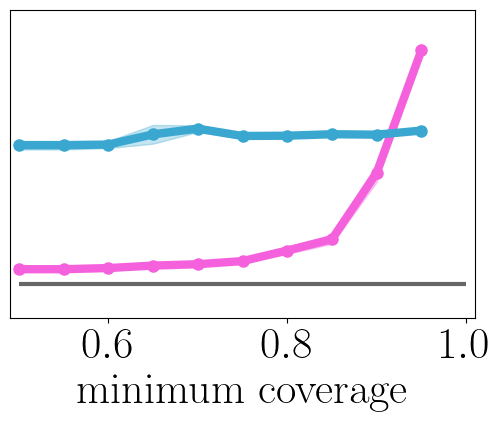

In [120]:
model = 'Forest-Depth-4'
measure = 'normalized-clustering-cost'

xlabel = 'minimum coverage'
ylabel = 'distortion'
fname = '../figures/relative_coverage/' + ylabel + '/' + dataset + '/' + model + '.png'
#fname = None

xaxis = False
if dataset == 'fashion':
    xaxis = True

yaxis = False
if model == 'IMM-outliers':
    yaxis = True

if not xaxis:
    xlabel = ''
if not yaxis:
    ylabel = ''

# Compute distortion with cost ratios:
cost_df = experiment_df[measure][model]
distortion_df = cost_df[[model, 'IMM', 'KMeans']].div(cost_df['KMeans'], level=1)
plot_df = distortion_df.groupby(level=0, axis=1).mean()
plot_std_df = distortion_df.groupby(level=0, axis=1).std()

plot_colors = [colormap(color_dict[mod]) for mod in plot_df.columns if mod != 'KMeans']
plot_cmap = ListedColormap(plot_colors)

# Domain:
#domain_df = mean_df['coverage'][model]
domain_array = np.array([list(np.linspace(0.5,1,11))] * len(plot_df.columns)).T
domain_df = pd.DataFrame(domain_array, columns = plot_df.columns)

xlim = (0.49, 1.01)
#ylim = (plot_df.min().min() - 0.05, plot_df.max().max() + 0.05)

if dataset == 'climate':
    ylim = (0.95, 1.1)
elif dataset == 'anuran':
    ylim = (0.95, 1.7)
elif dataset == 'covertype':
    ylim = (0.95, 1.4)
elif dataset == 'digits':
    ylim = (0.95, 1.7)
elif dataset == 'mnist':
    ylim = (0.95, 1.25)
elif dataset == 'fashion':
    ylim = (0.95, 1.4)

experiment_plotter(
    plot_df,
    plot_std_df,
    domain_df,
    xlabel = xlabel,
    ylabel = ylabel,
    cmap = plot_cmap,
    baseline_list = ['KMeans'],
    legend = False,
    xlim = xlim,
    ylim = ylim,
    xaxis = xaxis,
    yaxis = yaxis,
    filename = fname,
)

In [94]:
plot_df

,Forest-Depth-2,IMM,KMeans
0,1.147922,1.164817,1.0
1,1.147922,1.164817,1.0
2,1.148035,1.164972,1.0
3,1.172246,1.191042,1.0
4,1.172476,1.191208,1.0
5,1.172476,1.191208,1.0
6,1.172778,1.191141,1.0
7,1.215769,1.192420,1.0
8,1.309239,1.201376,1.0
9,1.558796,1.196573,1.0


In [50]:
cost_df

,Forest-Depth-3,KMeans,IMM,Forest-Depth-3,KMeans,IMM,Forest-Depth-3,KMeans,IMM,Forest-Depth-3,...,IMM,Forest-Depth-3,KMeans,IMM,Forest-Depth-3,KMeans,IMM,Forest-Depth-3,KMeans,IMM
,0,0,0,1,1,1,2,2,2,3,...,996,997,997,997,998,998,998,999,999,999
0,11.294596,11.283148,11.799721,11.679292,11.607169,12.009872,11.555148,11.555148,12.254047,11.677243,...,12.281484,11.425169,11.425169,12.142419,11.609445,11.547816,12.135557,11.468335,11.468335,12.129136
1,11.294596,11.283148,11.799721,11.679292,11.607169,12.009872,11.555148,11.555148,12.254047,11.677243,...,12.281484,11.425169,11.425169,12.142419,11.609445,11.547816,12.135557,11.468335,11.468335,12.129136
2,11.294596,11.283148,11.799721,11.679292,11.607169,12.009872,11.555148,11.555148,12.254047,11.677243,...,12.281484,11.425169,11.425169,12.142419,11.609445,11.547816,12.135557,11.468335,11.468335,12.129136
3,11.294596,11.283148,11.799721,11.679292,11.607169,12.009872,11.555148,11.555148,12.254047,11.677243,...,12.281484,11.425169,11.425169,12.142419,11.609445,11.547816,12.135557,11.468335,11.468335,12.129136
4,11.294596,11.283148,11.799721,11.679292,11.607169,12.009872,11.555148,11.555148,12.254047,11.677243,...,12.281484,11.425169,11.425169,12.142419,11.609445,11.547816,12.135557,11.468335,11.468335,12.129136
5,11.294596,11.283148,11.799721,11.679292,11.607169,12.009872,11.555148,11.555148,12.254047,11.677243,...,12.281484,11.425169,11.425169,12.142419,11.609445,11.547816,12.135557,11.468335,11.468335,12.129136
6,11.294596,11.283148,11.799721,11.679292,11.607169,12.009872,11.555148,11.555148,12.254047,11.677243,...,12.281484,11.425169,11.425169,12.142419,11.609445,11.547816,12.135557,11.468335,11.468335,12.129136
7,11.294596,11.283148,11.799721,11.679292,11.607169,12.009872,11.591133,11.573217,12.135496,11.677243,...,12.073957,11.691524,11.532400,12.078508,11.615126,11.540361,12.087968,11.584089,11.502442,12.011249
8,11.534050,11.469765,12.015344,11.679292,11.607169,12.009872,11.594192,11.507197,12.059866,11.705753,...,12.073957,11.691524,11.532400,12.078508,11.615126,11.540361,12.087968,11.584089,11.502442,12.011249


### Relative Comparisons

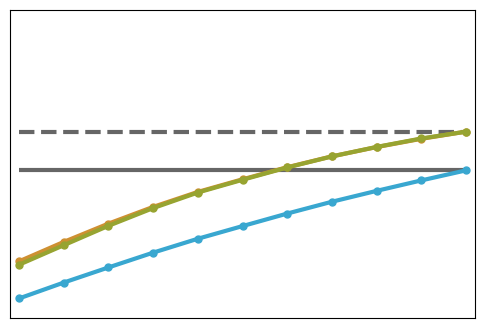

In [11]:
model = 'IMM-outliers'
measure = 'normalized-clustering-cost'
#measure = 'silhouette'
xlabel = 'minimum coverage'
ylabel = measure if measure != 'normalized-clustering-cost' else 'cost'
#fname = '../figures/relative_coverage/' + ylabel + '/' + dataset + '/' + model + '.png'
fname = None

xaxis = False
yaxis = False
if not xaxis:
    xlabel = ''
if not yaxis:
    ylabel = ''

plot_colors = [colormap(color_dict[mod]) for mod in mean_df[measure][model].columns]
plot_cmap = ListedColormap(plot_colors)
measure_df = mean_df[measure]

# Measurements
if measure == 'normalized-clustering-cost':
    norm = mean_df[measure]['KMeans']['KMeans'].iloc[0]
else:
    norm = 1

measure_df = mean_df[measure] / norm

plot_df = mean_df[measure][model]
plot_df['KMeans-Full'] = mean_df[measure]['KMeans']
plot_df['IMM-Full'] = mean_df[measure]['IMM']
plot_df /= norm

plot_std_df = std_df[measure][model]
plot_std_df['KMeans-Full'] = std_df[measure]['KMeans']
plot_std_df['IMM-Full'] = std_df[measure]['IMM']
plot_std_df /= norm

# Domain:
#domain_df = mean_df['coverage'][model]
domain_array = np.array([list(np.linspace(0.5,1,11))] * len(plot_df.columns)).T
domain_df = pd.DataFrame(domain_array, columns = plot_df.columns)

xlim = (0.49, 1.01)
ylim = (measure_df.min().min() - 0.05, measure_df.max().max() + 0.05)
experiment_plotter(
    plot_df,
    plot_std_df,
    domain_df,
    xlabel = xlabel,
    ylabel = ylabel,
    cmap = plot_cmap,
    baseline_list = ['KMeans-Full', 'IMM-Full'],
    legend = False,
    xlim = xlim,
    ylim = ylim,
    xaxis = xaxis,
    yaxis = yaxis,
    filename = fname,
)

In [45]:
measure_df.iloc[:-1,:].min().min()

0.5994177894081568

In [43]:
measure_df.iloc[:-1,:]

Forest-Depth-2                     Forest-Depth-4                      \
  Forest-Depth-2       IMM    KMeans Forest-Depth-4       IMM    KMeans   
0       0.913199  0.952760  0.907564       0.954897  0.997778  0.953366   
1       0.913199  0.952760  0.907564       0.954897  0.997778  0.953366   
2       0.913144  0.952588  0.907400       0.954897  0.997778  0.953366   
3       0.933855  0.966643  0.922464       0.954897  0.997778  0.953366   
4       0.941768  0.963070  0.924924       0.954897  0.997778  0.953366   
5       0.943795  0.963618  0.925460       0.955541  0.998474  0.953913   
6       0.947010  0.967484  0.927893       0.968245  1.011611  0.962904   
7       0.984088  1.003861  0.955180       0.983210  1.023799  0.972347   
8       1.025808  1.029643  0.975669       1.007274  1.040509  0.987615   
9       1.050404  1.040421  0.986173       1.027951  1.045777  0.991564   

  Forest-Depth-6                     Forest-Depth-IMM                      \
  Forest-Depth-6       IMM    KMeans Forest-Depth-IMM       IMM    KMeans   
0       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
1       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
2       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
3       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
4       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
5       0.959099  1.003779  0.958307         0.957047  1.001056  0.955973   
6       0.961706  1.006859  0.960309         0.962697  1.007255  0.960106   
7       0.982240  1.027696  0.976614         0.982616  1.026062  0.975459   
8       1.004813  1.042282  0.989587         1.005673  1.041641  0.989201   
9       1.029742  1.046504  0.992240         1.028840  1.046183  0.991742   

        IMM IMM-outliers                        KMeans  
        IMM          IMM IMM-outliers    KMeans KMeans  
0  1.054999     0.611483     0.599418  0.599418    1.0  
1  1.054999     0.656202     0.633585  0.633585    1.0  
2  1.054999     0.727449     0.691412  0.681718    1.0  
3  1.054999     0.776510     0.753359  0.715553    1.0  
4  1.054999     0.854952     0.834616  0.801146    1.0  
5  1.054999     0.886185     0.879428  0.830791    1.0  
6  1.054999     0.924107     0.914725  0.859588    1.0  
7  1.054999     0.974387     0.962357  0.910514    1.0  
8  1.054999     1.006210     0.997370  0.942473    1.0  
9  1.054999     1.029497     1.029497  0.969937    1.0

In [5]:
# Load experiment results
dataset = 'climate'
fname = "../data/experiments/" + dataset + "/explanation_tree.csv"
explanation_tree_df = pd.read_csv(fname, index_col=0)

In [6]:
explanation_tree_df

,normalized-clustering-cost,overlap,coverage,max-rule-legnth,weighted-average-rule-length
0,11.485357,1.0,0.898256,5,3.576052
